## Import necessary libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
import pickle

## Load data from NAB dataset

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/ambient_temperature_system_failure.csv')
print(f"Dataset loaded with shape: {data.shape}")

Dataset loaded with shape: (7267, 2)


In [3]:
data.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


## Convert timestamp to datetime

In [5]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Exploratory Data Analysis
print("\nBasic statistics:")
print(data.describe())

# Check for missing values and duplicates
print(f"\nMissing values: {data.isnull().sum().sum()}")
print(f"Duplicate rows: {data.duplicated().sum()}")


Basic statistics:
                           timestamp        value
count                           7267  7267.000000
mean   2013-12-17 01:43:01.477914112    71.242433
min              2013-07-04 00:00:00    57.458406
25%              2013-10-01 13:30:00    68.369411
50%              2013-12-19 04:00:00    71.858493
75%              2014-03-06 01:30:00    74.430958
max              2014-05-28 15:00:00    86.223213
std                              NaN     4.247509

Missing values: 0
Duplicate rows: 0


## Remove duplicates and missing values if any

In [6]:
data_cleaned = data.dropna().drop_duplicates()
print(f"Clean dataset shape: {data_cleaned.shape}")

Clean dataset shape: (7267, 2)


In [ ]:
data_cleaned.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


##  Visualize the data

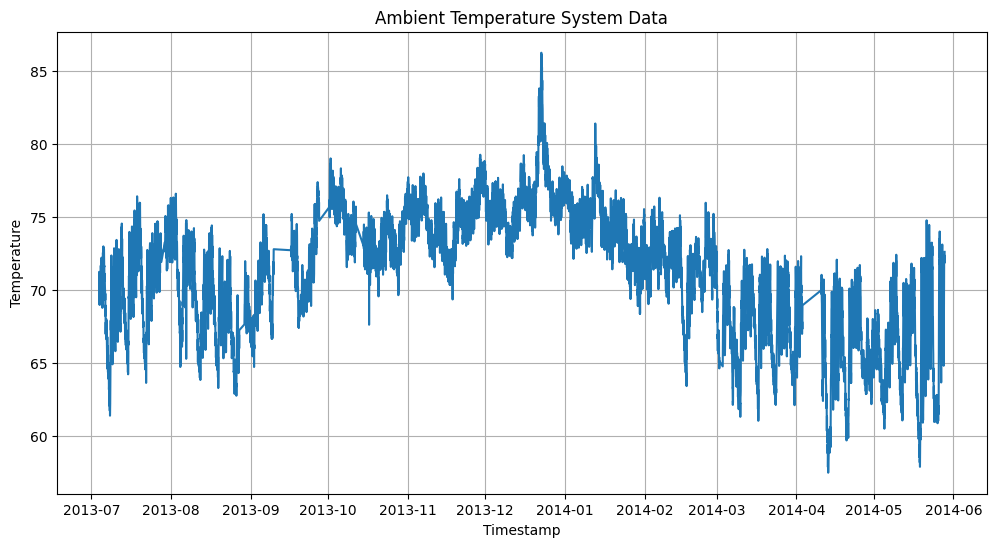

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(data_cleaned['timestamp'], data_cleaned['value'])
plt.title('Ambient Temperature System Data')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.grid(True)
plt.show()

## Create rolling statistics (moving averages and standard deviations) over different window sizes


In [9]:
windows = [10, 20, 30]  # Define the window sizes for rolling statistics

for w in windows:
    # Calculate rolling mean with a window of size 'w' for each window size (e.g., 10, 20, 30)
    # When w=10, it means the rolling window will consist of the last 10 data points for each computation.
    data_cleaned[f'rolling_mean_{w}'] = data_cleaned['value'].rolling(window=w).mean()
    
    # Calculate rolling standard deviation with a window of size 'w' for each window size
    # The standard deviation will be calculated over the last 'w' data points, providing a measure of volatility or variation.
    data_cleaned[f'rolling_std_{w}'] = data_cleaned['value'].rolling(window=w).std()

# Extract time-based features from the timestamp column
data_cleaned['hour'] = data_cleaned['timestamp'].dt.hour  # Extract hour from timestamp (0-23)
data_cleaned['day_of_week'] = data_cleaned['timestamp'].dt.dayofweek  # Extract day of the week (0=Monday, 6=Sunday)
# Create a binary feature indicating whether the day is a weekend (Saturday or Sunday)
data_cleaned['is_weekend'] = data_cleaned['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Create lag features, shifting the 'value' column by 1, 3, and 5 time steps
# These features capture the relationship between past and current data points
for lag in [1, 3, 5]:
    # Shift the 'value' column by the number of steps specified in 'lag'
    # For example, when lag=1, the new feature 'lag_1' will have the previous value shifted by 1 position:
    # Example of lag_1:
    # lag_1 = [NaN, 5, 7, 9, 10, 6, 3, 8, 12, 10]
    data_cleaned[f'lag_{lag}'] = data_cleaned['value'].shift(lag)

# Calculate the difference between the current value and the previous value (difference feature)
# This helps in capturing trends or changes in the data over time
data_cleaned['diff_1'] = data_cleaned['value'].diff()
data_processed = data_cleaned.dropna()

print(f"Processed dataset shape after feature engineering: {data_processed.shape}")

Processed dataset shape after feature engineering: (7238, 15)


In [10]:
data_processed.head()

,timestamp,value,rolling_mean_10,rolling_std_10,rolling_mean_20,rolling_std_20,rolling_mean_30,rolling_std_30,hour,day_of_week,is_weekend,lag_1,lag_3,lag_5,diff_1
29,2013-07-05 05:00:00,69.748963,71.081448,0.808638,70.927375,0.753399,70.521082,0.953241,5,4,0,70.432826,70.977001,71.342742,-0.683863
30,2013-07-05 06:00:00,68.749382,70.747225,1.010287,70.866591,0.874442,70.483367,1.000650,6,4,0,69.748963,70.243882,71.586728,-0.999581
31,2013-07-05 07:00:00,69.351627,70.527080,1.054081,70.806363,0.936245,70.421080,1.011302,7,4,0,68.749382,70.432826,70.977001,0.602244
32,2013-07-05 08:00:00,68.853148,70.193626,0.996230,70.733645,1.028923,70.353591,1.046709,8,4,0,69.351627,69.748963,70.243882,-0.498478
33,2013-07-05 09:00:00,70.317910,70.160421,0.984798,70.737228,1.027260,70.398875,1.013161,9,4,0,68.853148,68.749382,70.432826,1.464761


## Visualize feature correlations

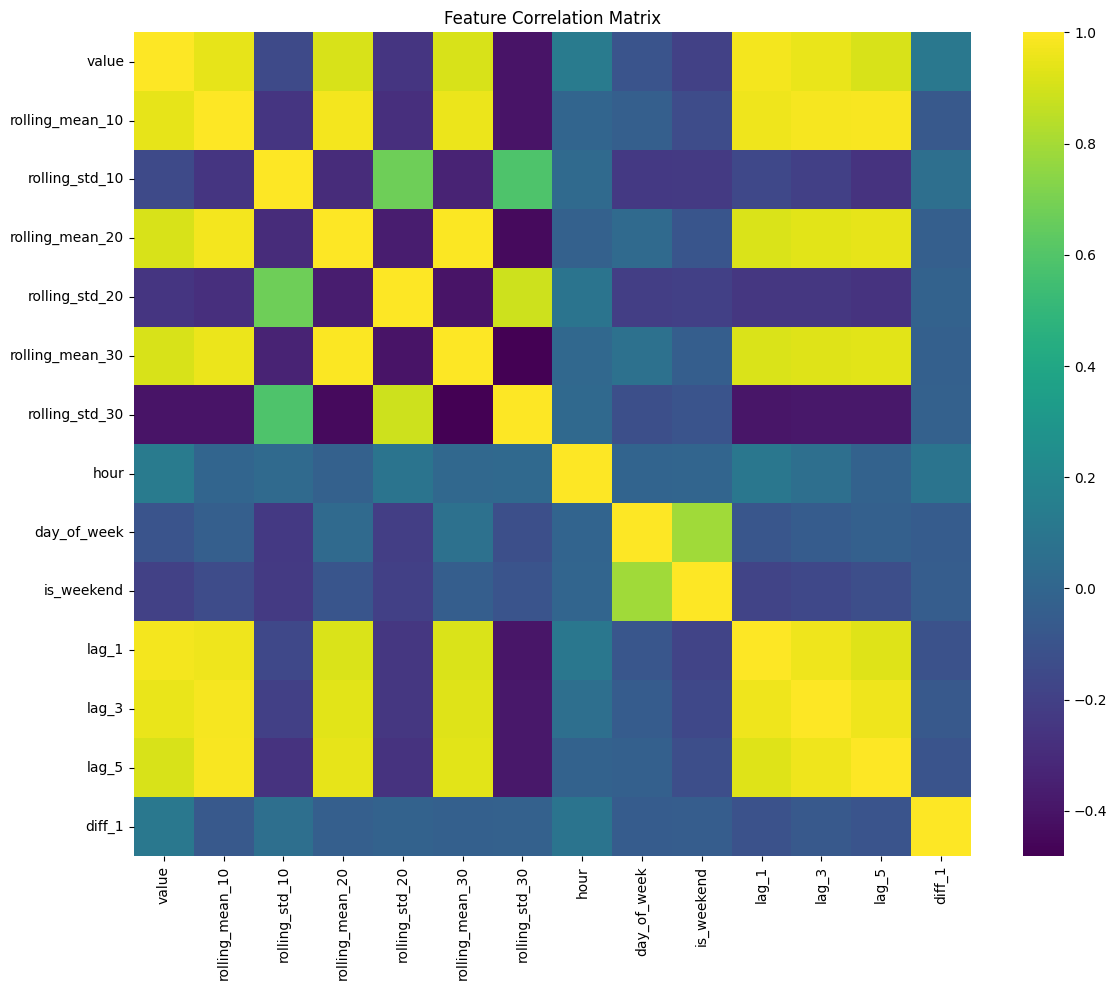

In [11]:
plt.figure(figsize=(12, 10))
feature_cols = [col for col in data_processed.columns if col not in ['timestamp']]
sns.heatmap(data_processed[feature_cols].corr(), annot=False, cmap='viridis')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## Scale numbers

In [12]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data_processed[feature_cols])
data_scaled = pd.DataFrame(scaled_features, columns=feature_cols)
data_scaled['timestamp'] = data_processed['timestamp'].values

In [13]:
data_scaled.head()

,value,rolling_mean_10,rolling_std_10,rolling_mean_20,rolling_std_20,rolling_mean_30,rolling_std_30,hour,day_of_week,is_weekend,lag_1,lag_3,lag_5,diff_1,timestamp
0,0.427278,0.462975,0.129192,0.468430,0.070805,0.462287,0.088269,0.217391,0.666667,0.0,0.451052,0.469970,0.482685,0.386182,2013-07-05 05:00:00
1,0.392527,0.450597,0.172593,0.466012,0.094119,0.460714,0.098448,0.260870,0.666667,0.0,0.427278,0.444483,0.491167,0.367156,2013-07-05 06:00:00
2,0.413464,0.442444,0.182019,0.463616,0.106024,0.458116,0.100735,0.304348,0.666667,0.0,0.392527,0.451052,0.469970,0.463684,2013-07-05 07:00:00
3,0.396135,0.430094,0.169568,0.460723,0.123875,0.455302,0.108338,0.347826,0.666667,0.0,0.413464,0.427278,0.444483,0.397353,2013-07-05 08:00:00
4,0.447057,0.428864,0.167107,0.460866,0.123555,0.457190,0.101135,0.391304,0.666667,0.0,0.396135,0.392527,0.451052,0.515661,2013-07-05 09:00:00


## Set seeds for reproducibility

In [14]:
np.random.seed(42)
tf.random.set_seed(42)

## Isolation Forest (Statistical approach)


In [15]:
print("Training Isolation Forest model...")
isolation_forest = IsolationForest(
    n_estimators=100, 
    contamination=0.01,  # Expected proportion of anomalies
    random_state=42,
    n_jobs=-1
)

# Extract features for isolation forest (exclude timestamp)
X_iforest = data_scaled.drop('timestamp', axis=1).values

# Train the model
isolation_forest.fit(X_iforest)

# Save the trained model
with open('isolation_forest_model.pkl', 'wb') as f:
    pickle.dump(isolation_forest, f)

print("Isolation Forest model trained and saved.")

Training Isolation Forest model...
Isolation Forest model trained and saved.


## LSTM Autoencoder (Deep Learning approach)

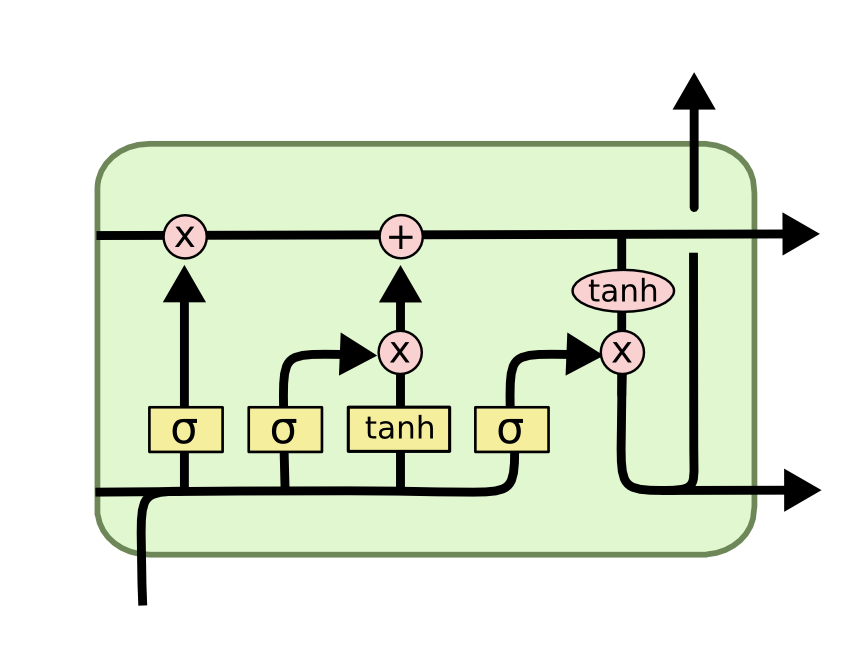

In [16]:
print("Preparing data for LSTM Autoencoder...")

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    X = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
    return np.array(X)

# Prepare sequence data - use value column as the main signal
sequence_length = 20
X_train_scaled = data_scaled['value'].values.reshape(-1, 1)
X_train_seq = create_sequences(X_train_scaled, sequence_length)
print(f"Sequence data shape: {X_train_seq.shape}")

# Build LSTM Autoencoder
print("Building and training LSTM Autoencoder...")
input_dim = X_train_seq.shape[1:]  # (sequence_length, 1)

# Encoder
inputs = Input(shape=input_dim)
encoder = LSTM(32, activation='relu', return_sequences=True)(inputs)
encoder = LSTM(16, activation='relu', return_sequences=False)(encoder)
encoder = Dense(8, activation='relu')(encoder)

# Decoder
decoder = RepeatVector(sequence_length)(encoder)
decoder = LSTM(16, activation='relu', return_sequences=True)(decoder)
decoder = LSTM(32, activation='relu', return_sequences=True)(decoder)
decoder = TimeDistributed(Dense(1))(decoder)

# Autoencoder model
autoencoder = Model(inputs, decoder)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# Train with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = autoencoder.fit(
    X_train_seq, X_train_seq,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Save the trained autoencoder model
autoencoder.save('lstm_autoencoder_model.h5')
print("LSTM Autoencoder model trained and saved.")

Preparing data for LSTM Autoencoder...
Sequence data shape: (7218, 20, 1)
Building and training LSTM Autoencoder...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 20, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 20, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 20, 16)         │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 20, 32)         │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 1)          │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,529 (60.66 KB)

 Trainable params: 15,529 (60.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.1271 - val_loss: 0.0073
Epoch 2/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0033 - val_loss: 0.0045
Epoch 3/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0017 - val_loss: 0.0037
Epoch 4/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 5/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0012 - val_loss: 0.0030
Epoch 6/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 7/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 8/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 9/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 10/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 11/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 12/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 9

LSTM Autoencoder model trained and saved.


## Plot training history

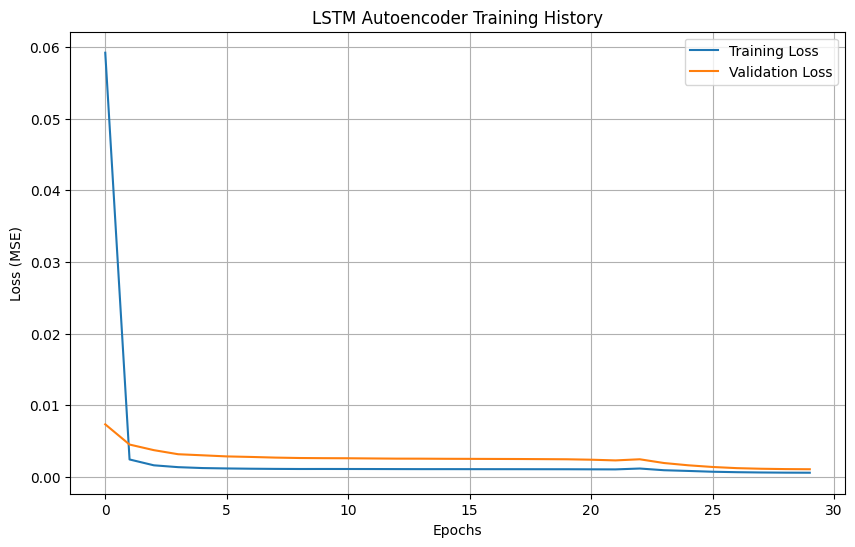

In [17]:

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Autoencoder Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

##  Evaluate Isolation Forest

In [18]:
# Get anomaly predictions (-1 for anomalies, 1 for normal)
iforest_predictions = isolation_forest.predict(X_iforest)
# Convert to binary (1 for anomalies, 0 for normal)
iforest_anomalies = np.where(iforest_predictions == -1, 1, 0)
# Get anomaly scores
iforest_scores = -isolation_forest.decision_function(X_iforest)

##  Evaluate LSTM Autoencoder

In [19]:
# Generate reconstructions
reconstructions = autoencoder.predict(X_train_seq)
# Compute reconstruction error (MSE)
mse = np.mean(np.square(X_train_seq - reconstructions), axis=(1, 2))
# Determine anomaly threshold (e.g., 95th percentile)
threshold = np.percentile(mse, 95)
print(f"Autoencoder anomaly threshold: {threshold}")

# Create a temporary series to hold autoencoder anomalies, initialized with zeros
ae_anomalies = np.zeros(len(data_processed))
# Mark anomalies where reconstruction error exceeds threshold
# Make sure indices match (sequence_length offset)
for i in range(len(mse)):
    if mse[i] > threshold:
        ae_anomalies[i + sequence_length] = 1

# Combine results into a DataFrame
results = pd.DataFrame({
    'timestamp': data_processed['timestamp'],
    'value': data_processed['value'],
    'iforest_anomaly': iforest_anomalies,
    'iforest_score': iforest_scores,
    'ae_anomaly': ae_anomalies  # Now correctly sized array
})

# Create ensemble model (combine both approaches)
results['ensemble_anomaly'] = np.where(
    (results['iforest_anomaly'] == 1) | (results['ae_anomaly'] == 1), 
    1, 0
)

# Count anomalies detected by each method
print(f"Anomalies detected by Isolation Forest: {results['iforest_anomaly'].sum()}")
print(f"Anomalies detected by LSTM Autoencoder: {results['ae_anomaly'].dropna().astype(int).sum()}")
print(f"Anomalies detected by Ensemble approach: {results['ensemble_anomaly'].sum()}")

226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Autoencoder anomaly threshold: 0.0012246916968443318
Anomalies detected by Isolation Forest: 73
Anomalies detected by LSTM Autoencoder: 361
Anomalies detected by Ensemble approach: 413


## Visualize the results

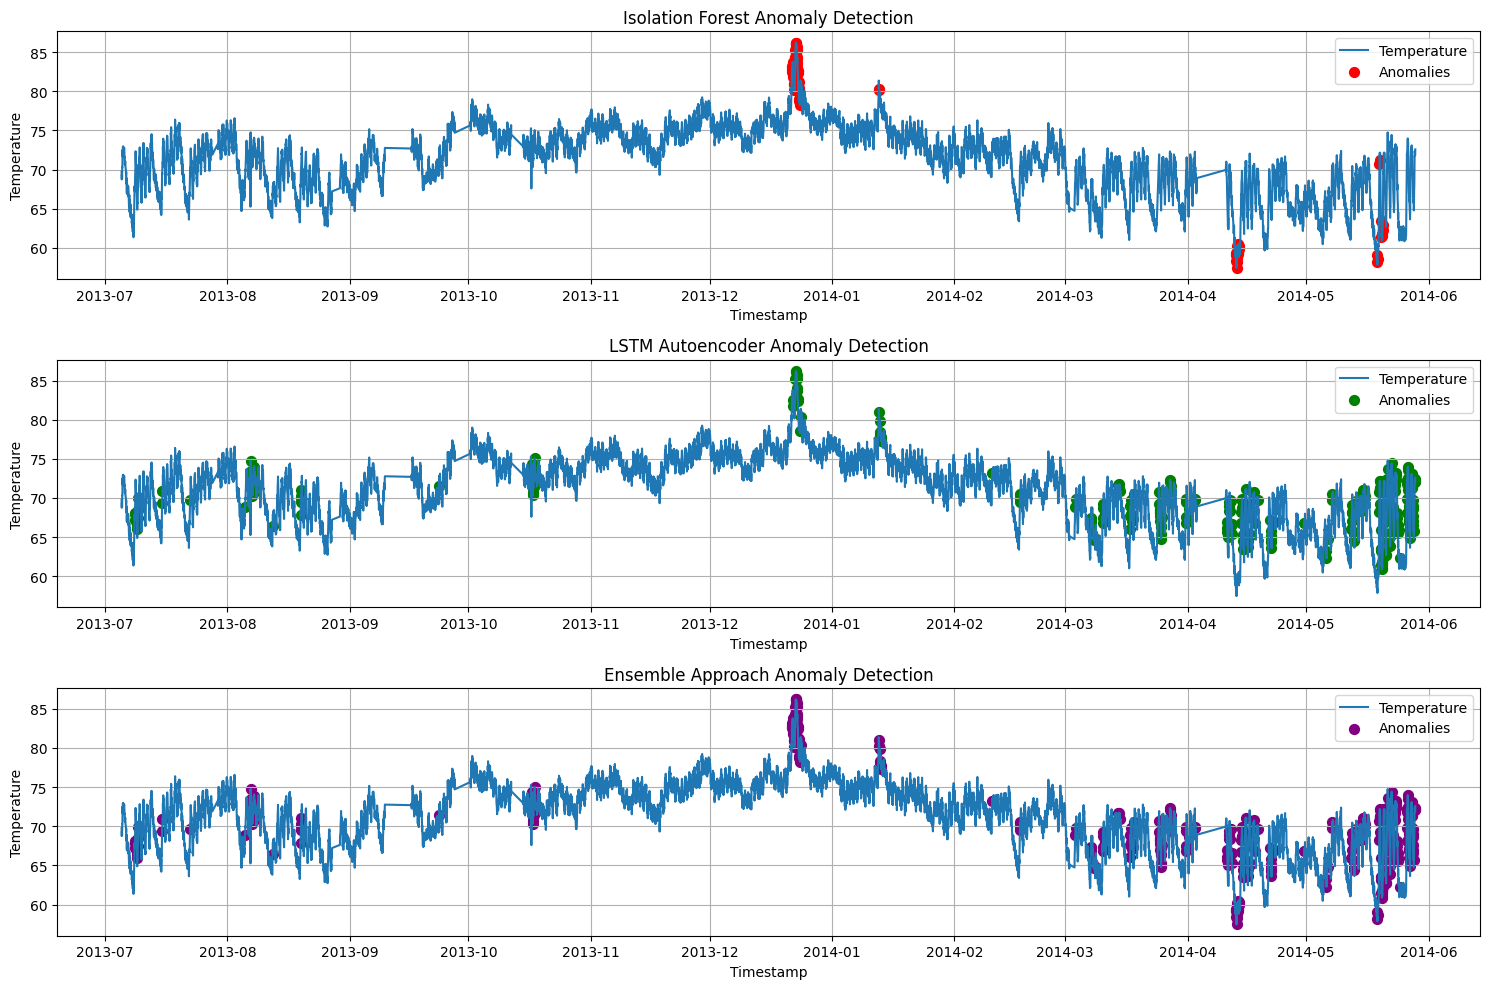

In [20]:
plt.figure(figsize=(15, 10))

# Plot 1: Original data with Isolation Forest anomalies
plt.subplot(3, 1, 1)
plt.plot(results["timestamp"], results["value"], label="Temperature")
anomaly_points = results[results["iforest_anomaly"] == 1]
plt.scatter(
    anomaly_points["timestamp"],
    anomaly_points["value"],
    color="red",
    label="Anomalies",
    s=50,
)
plt.title("Isolation Forest Anomaly Detection")
plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)

# Plot 2: Original data with Autoencoder anomalies
plt.subplot(3, 1, 2)
plt.plot(results["timestamp"], results["value"], label="Temperature")
ae_anomaly_points = results[results["ae_anomaly"] == 1]
plt.scatter(
    ae_anomaly_points["timestamp"],
    ae_anomaly_points["value"],
    color="green",
    label="Anomalies",
    s=50,
)
plt.title("LSTM Autoencoder Anomaly Detection")
plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)


# Plot 3: Original data with Ensemble anomalies
plt.subplot(3, 1, 3)
plt.plot(results["timestamp"], results["value"], label="Temperature")
ensemble_anomaly_points = results[results["ensemble_anomaly"] == 1]
plt.scatter(
    ensemble_anomaly_points["timestamp"],
    ensemble_anomaly_points["value"],
    color="purple",
    label="Anomalies",
    s=50,
)
plt.title("Ensemble Approach Anomaly Detection")
plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Save results to CSV

In [21]:
results.to_csv('anomaly_detection_results.csv', index=False)
print("Results saved to 'anomaly_detection_results.csv'")

Results saved to 'anomaly_detection_results.csv'
